In [1]:
%matplotlib widget

In [2]:
import sys
import os
import time
import math as math
from datetime import datetime
import numpy as np
import astropy as ast
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, Column
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from astropy.time import Time
from photutils.aperture import EllipticalAnnulus, aperture_photometry
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate
import scipy.constants
import scipy.special
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.interpolate
from scipy.interpolate import CubicSpline
import glob2
import shutil
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from tqdm.notebook import tqdm as tqdm

import Utility3_4 as ut

pi = sp.constants.pi
k= sp.constants.k
q_e = sp.constants.e

DimY = 1096
DimX = 1936

DisectString = '\1/'
BackSlash = DisectString[0]
ForwardSlash = '/'

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def gauss(x, norm, cent, width):
    return norm*np.exp(-(x-cent)**2 / (2*width**2))

def doubleGauss(x, n1, n2, c1, c2, w1, w2):
    return gauss(x, n1, c1, w1) + gauss(x, n2, c2, w2)

def quad(x, a, b, c):
    return (a * x**2) + (b * x) + c

def fitFunc(x, n1, n2, c1, c2, w1, w2, a, b, c):
    return doubleGauss(x, n1, n2, c1, c2, w1, w2) + quad(x, a, b, c)

def gaussBack(x, norm, cent, width, a, b, c):
    return gauss(x, norm, cent, width) + quad(x, a, b, c)

def line(x, m, b):
    return (m * x) + b

In [4]:
def ROItoPoints(ROI):
    
    x1 = ROI[0]
    y1 = ROI[2]

    x2 = ROI[1]
    y2 = ROI[2]
    
    x3 = ROI[1]
    y3 = ROI[3]
    
    x4 = ROI[0]
    y4 = ROI[3]
    
    x = [x1,x2,x3,x4]
    y = [y1,y2,y3,y4]
    
    return x, y

def MakeFileNamesList(datadirectory,filepattern):
    FileNamesList = glob2.glob(datadirectory + filepattern)
    
    return FileNamesList

def MakeImagesList(FileNamesList,IndexOfFitsImage):
    
    ImagesList = []
    
    for file in FileNamesList:
        
        #File = directory + file
        
        h = pyfits.open(file)
        img_data = h[IndexOfFitsImage].data
        header = h[IndexOfFitsImage].header
        '''
        exposure = header['EXPOSURE']
        gain = header['GAIN']
        DateAndTime = header['DATETIME']
        CamID = header['CAM_ID']
        CamFreeName = header['CAMFREE']
        '''
        image_and_metadata = [0,0,0,0,0,0]
        
        image_and_metadata[0] = img_data
        image_and_metadata[1] = header['EXPOSURE']
        image_and_metadata[2] = header['GAIN']
        image_and_metadata[3] = header['DATE']
        image_and_metadata[4] = header['TEMP']
        image_and_metadata[5] = file #Added Special Here the string of the corresponding file name
        #image_and_metadata[4] = header['CAM_ID']
        #image_and_metadata[5] = header['CAMFREE']
        
        ImagesList.append(image_and_metadata)
        
    return ImagesList

def MakeImagesListCSV(FileNamesList):
    
    ImagesList = []
    
    for file in FileNamesList:
        
        img_data = np.loadtxt(file, delimiter=',')
        
        image_and_metadata = [0,0,0,0,0,0]
        
        image_and_metadata[0] = img_data
        image_and_metadata[5] = file
        
        ImagesList.append(image_and_metadata)
        
    return ImagesList

def MakeCroppedImagesList(FileNamesList,ROI,IndexOfFitsImage):
    
    ImagesList = []
    
    for file in FileNamesList:
        
        #File = directory + file
        
        h = pyfits.open(file)
        img_data = h[IndexOfFitsImage].data
        header = h[IndexOfFitsImage].header

        image_and_metadata = [0,0,0,0,0,0]
        
        image_and_metadata[0] = img_data[ROI[2]:ROI[3],ROI[0]:ROI[1]]
        image_and_metadata[1] = header['EXPOSURE']
        image_and_metadata[2] = header['GAIN']
        image_and_metadata[3] = header['DATE']
        image_and_metadata[4] = header['TEMP']
        image_and_metadata[5] = file
        
        ImagesList.append(image_and_metadata)
        
    return ImagesList

def MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False):
    HistBins = [MinX]
    PlotBins = [MinX]
    
    if BinSize != False:
        BinsPerUnitX = 1/BinSize
        BinsPerUnitX = int(BinsPerUnitX)
        ActualBinSize = 1/BinsPerUnitX
        print("Actual Bin Size: " + str(ActualBinSize))
        
    
    for i in range(int((MaxX-MinX)*BinsPerUnitX) + 1):
        HistBins.append(HistBins[i]+1/BinsPerUnitX)
        PlotBins.append(PlotBins[i]+1/BinsPerUnitX)
        
    HistBins = np.array(HistBins)
    HistBins = HistBins - 0.5/BinsPerUnitX
    
    PlotBins = np.array(PlotBins)
    PlotBins = PlotBins[:-1]
    
    theHistogram = np.histogram(ToHistogramArray, bins = HistBins)
    theHistogram = theHistogram[0]
    
    print("Only Valid if Integer: " + str((MaxX-MinX)*BinsPerUnitX))
    print("Bin Size: " + str(1/BinsPerUnitX))
    
    
    return theHistogram, PlotBins

def ChiSquaredOfFit1D(DataArray,ErrorArray,FitArray,NumberOfFitParameters):
    
    ChiSquared = 0
    NumberDataPoints = np.size(DataArray)
    
    for i in tqdm(range(NumberDataPoints)):
        ChiSquared += ((FitArray[i] - DataArray[i])**2)/((ErrorArray[i])**2)
        
    dof = NumberDataPoints - NumberOfFitParameters
    ReducedChiSquared = ChiSquared/dof
    
    return ChiSquared, ReducedChiSquared, dof

def ChiSquaredOfFit1D_NoProgressBar(DataArray,ErrorArray,FitArray,NumberOfFitParameters):
    
    ChiSquared = 0
    NumberDataPoints = np.size(DataArray)
    
    for i in range(NumberDataPoints):
        ChiSquared += ((FitArray[i] - DataArray[i])**2)/((ErrorArray[i])**2)
        
    dof = NumberDataPoints - NumberOfFitParameters
    ReducedChiSquared = ChiSquared/dof
    
    return ChiSquared, ReducedChiSquared, dof

In [5]:
#Load in Events 
SetName_490p5 = 'XM2_YP1_490p5eV'
SetName_520 = 'X0_Y0_520eV'
SetName_981 = 'X0_YP2_981eV'

Directory2_490p5 = 'SteadyStateDataSets/Gain_Data/' + SetName_490p5 + '/CroppedROI1/'
Directory2_520 = 'SteadyStateDataSets/Gain_Data/' + SetName_520 + '/CroppedROI1/'
Directory2_981 = 'SteadyStateDataSets/Gain_Data/' + SetName_981 + '/CroppedROI1/'

AllEventSignals = np.loadtxt(Directory2_490p5 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_490p5, BinsX_490p5 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

AllEventSignals = np.loadtxt(Directory2_520 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_520, BinsX_520 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

AllEventSignals = np.loadtxt(Directory2_981 + 'AllEventSignalsROI1_OS_CompositeDark2' +'.csv', delimiter=',')
ToHistogramArray = AllEventSignals
MinX = 0
MaxX = 200
BinsPerUnitX = 1
HistogramY_981, BinsX_981 = MakeHistogramSet(ToHistogramArray,MinX,MaxX,BinsPerUnitX,BinSize=False)

Only Valid if Integer: 200
Bin Size: 1.0
Only Valid if Integer: 200
Bin Size: 1.0
Only Valid if Integer: 200
Bin Size: 1.0


In [7]:
#Curve Fitting

CentroidsADU = []
CentroidsErrADU = []
SigmaADU = []
SigmaErrADU = []
Energies = []

wf = 3.64

#490.5 eV
Energy = 490.5
test = [6700, 150, 68, 122, 1, 1] #[n1, n2, c1, c2, w1, w2]

xAxis = BinsX_490p5
yAxis = HistogramY_490p5

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

CentroidsADU.append(Centroid)
CentroidsErrADU.append(CentroidErr)
SigmaADU.append(Sigma)
SigmaErrADU.append(SigmaErr)
Energies.append(Energy)

xAxis_490p5 = BinsX_490p5
yAxis_490p5 = HistogramY_490p5
Fit_yAxis_490p5 = doubleGauss(xAxis_490p5, *popt)

#520.0 eV
Energy = 520.0
test = [3800, 70, 68, 125, 1, 1] #[n1, n2, c1, c2, w1, w2]

xAxis = BinsX_520
yAxis = HistogramY_520

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

CentroidsADU.append(Centroid)
CentroidsErrADU.append(CentroidErr)
SigmaADU.append(Sigma)
SigmaErrADU.append(SigmaErr)
Energies.append(Energy)

xAxis_520 = BinsX_520
yAxis_520 = HistogramY_520
Fit_yAxis_520 = doubleGauss(xAxis_520, *popt)

#981 eV
Energy = 981.0
test = [4750, 930, 125, 72, 1, 1] #[n1, n2, c1, c2, w1, w2]

xAxis = BinsX_981
yAxis = HistogramY_981

popt, pcov = curve_fit(doubleGauss, xAxis, yAxis, p0=test)
perr = np.sqrt(np.diag(pcov))

Centroid = popt[2]
CentroidErr = perr[2]
Sigma = popt[4]
SigmaErr = perr[4]

CentroidsADU.append(Centroid)
CentroidsErrADU.append(CentroidErr)
SigmaADU.append(Sigma)
SigmaErrADU.append(SigmaErr)
Energies.append(Energy)

xAxis_981 = BinsX_981
yAxis_981 = HistogramY_981
Fit_yAxis_981 = doubleGauss(xAxis_981, *popt)

CentroidsADU = np.array(CentroidsADU)
CentroidsErrADU = np.array(CentroidsErrADU)
SigmaADU = np.array(SigmaADU)
SigmaErrADU = np.array(SigmaErrADU)
Energies = np.array(Energies)

In [8]:
nMu490p5 = CentroidsADU[0]
nErrMu490p5 = CentroidsErrADU[0]
nSigma490p5 = SigmaADU[0]
nErrSigma490p5 = SigmaErrADU[0]

nMu520 = CentroidsADU[1]
nErrMu520 = CentroidsErrADU[1]
nSigma520 = SigmaADU[1]
nErrSigma520 = SigmaErrADU[1]

nMu981 = CentroidsADU[2]
nErrMu981 = CentroidsErrADU[2]
nSigma981 = SigmaADU[2]
nErrSigma981 = SigmaErrADU[2]

nMu981u = popt[3]
nErrMu981u = perr[3]
nSigma981u = popt[5]
nErrSigma981u = perr[5]

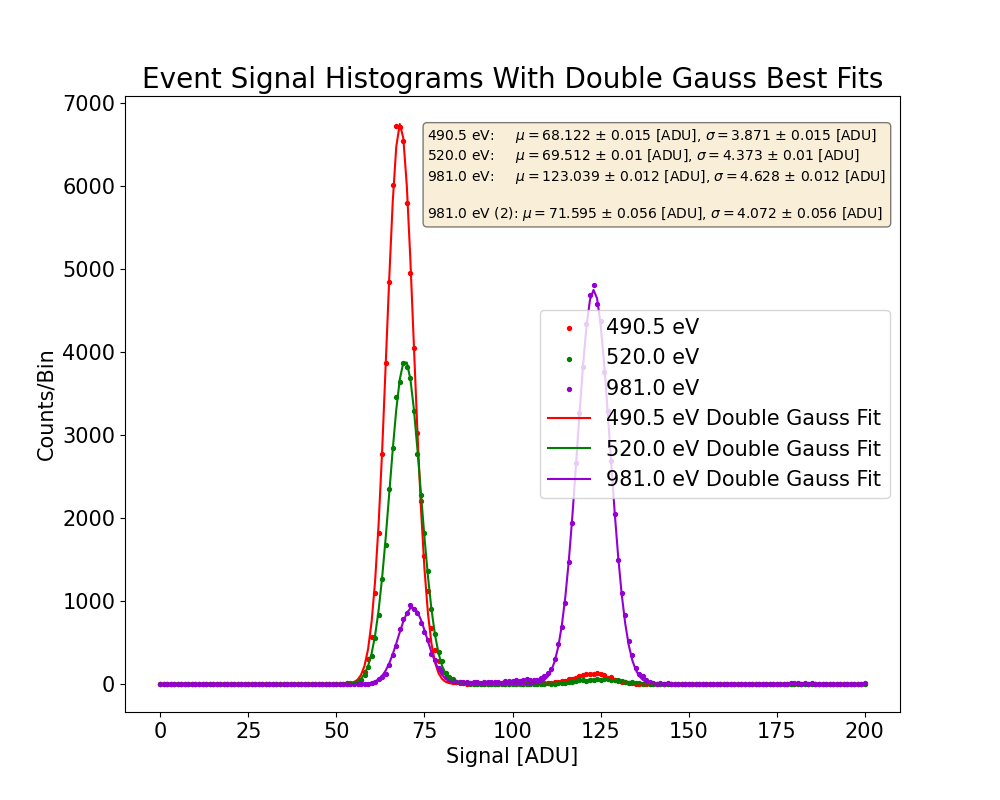

490.5 eV:     $\mu = $68.122 $\pm$ 0.015 [ADU], $\sigma = $3.871 $\pm$ 0.015 [ADU]
520.0 eV:     $\mu = $69.512 $\pm$ 0.01 [ADU], $\sigma = $4.373 $\pm$ 0.01 [ADU]
981.0 eV:     $\mu = $123.039 $\pm$ 0.012 [ADU], $\sigma = $4.628 $\pm$ 0.012 [ADU]
 
981.0 eV (2): $\mu = $71.595 $\pm$ 0.056 [ADU], $\sigma = $4.072 $\pm$ 0.056 [ADU]


In [9]:
#Plotting
Mu490p5 = str(round(CentroidsADU[0],3))
ErrMu490p5 = str(round(CentroidsErrADU[0],3))
Sigma490p5 = str(round(SigmaADU[0],3))
ErrSigma490p5 = str(round(SigmaErrADU[0],3))

Mu520 = str(round(CentroidsADU[1],3))
ErrMu520 = str(round(CentroidsErrADU[1],3))
Sigma520 = str(round(SigmaADU[1],3))
ErrSigma520 = str(round(SigmaErrADU[1],3))

Mu981 = str(round(CentroidsADU[2],3))
ErrMu981 = str(round(CentroidsErrADU[2],3))
Sigma981 = str(round(SigmaADU[2],3))
ErrSigma981 = str(round(SigmaErrADU[2],3))

Centroid = popt[3]
CentroidErr = perr[3]
Sigma = popt[5]
SigmaErr = perr[5]

Mu981u = str(round(Centroid,3))
ErrMu981u = str(round(CentroidErr,3))
Sigma981u = str(round(Sigma,3))
ErrSigma981u = str(round(SigmaErr,3))

textstr = '\n'.join((
    r'490.5 eV:     $\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " [ADU], " + "$\sigma = $" + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " [ADU]",
    r'520.0 eV:     $\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + " [ADU], " + "$\sigma = $" + Sigma520+ " $\pm$ " + ErrSigma520 + " [ADU]",
    r'981.0 eV:     $\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " [ADU], " + "$\sigma = $" + Sigma981+ " $\pm$ " + ErrSigma981 + " [ADU]",
    r' ',
    r'981.0 eV (2): $\mu = $' + Mu981u + " $\pm$ " + ErrMu981u + " [ADU], " + "$\sigma = $" + Sigma981u+ " $\pm$ " + ErrSigma981u + " [ADU]"))


plt.figure(figsize=(10,8))
plt.clf()
ax=plt.gca()
plt.scatter(xAxis_490p5,yAxis_490p5, color = 'red',s=8 , label = '490.5 eV')
plt.scatter(xAxis_520,yAxis_520, color = 'green',s=8 , label = '520.0 eV')
plt.scatter(xAxis_981,yAxis_981, color = 'darkviolet',s=8 , label = '981.0 eV')

plt.plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
plt.plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
plt.plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.title('Event Signal Histograms With Double Gauss Best Fits')
plt.xlabel('Signal [ADU]')
plt.ylabel('Counts/Bin')
plt.legend(loc = 'center right')
plt.show()

print(textstr)

  0%|          | 0/3 [00:00<?, ?it/s]

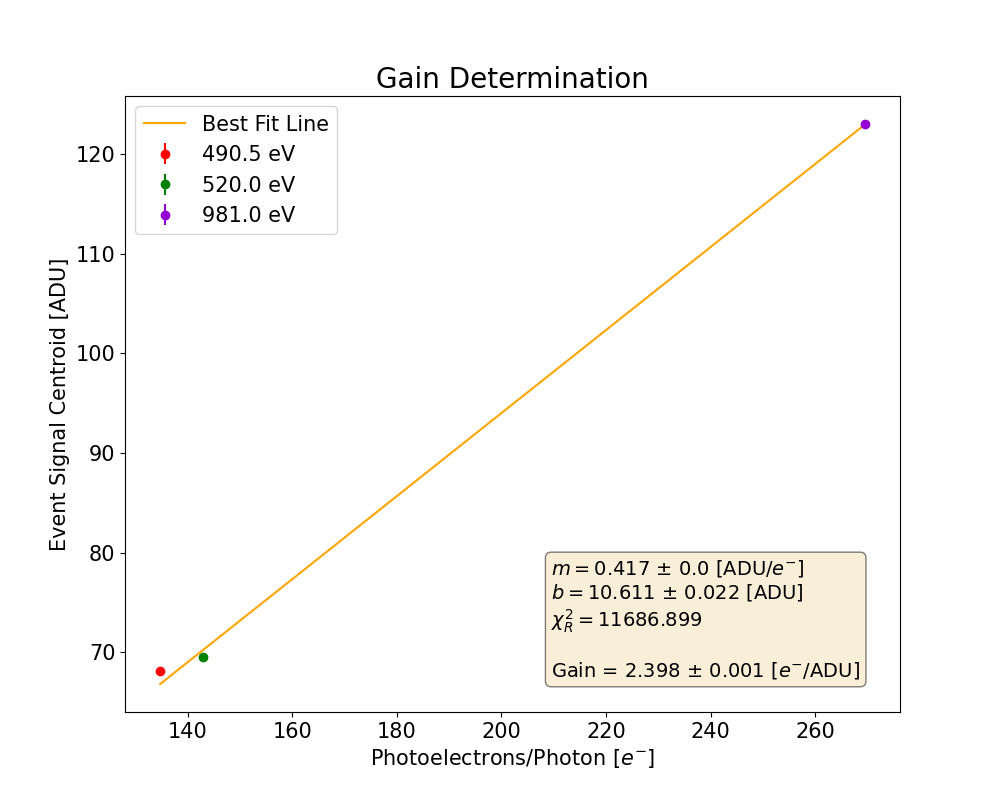

_________________________________
 Best Fit Parameters
 -----------------------------
 Slope: 0.41698 [ADU/e-]
 Slope Err: 0.00011 [ADU/e-]
 Gain: 2.398 [e-/ADU]
 Gain Err: 0.001 [e-/ADU]
 Reduced Chi Squared: 11686.899


In [10]:
#Gain Determination With CentroidsErrADU as error
error = CentroidsErrADU

Photoelectrons = Energies/wf

popt3, pcov3 = curve_fit(line, Photoelectrons, CentroidsADU, sigma=error, absolute_sigma=True)
perr3 = np.sqrt(np.diag(pcov3))

Slope = popt3[0]
SlopeErr = perr3[0]

b = popt3[1]
bErr = perr3[1]

Gain = 1/Slope
GainErr = SlopeErr/(Slope**2)

DataArray = CentroidsADU
ErrorArray = error
FitArray = line(Photoelectrons, *popt3)
NumberOfFitParameters = 2
ChiSquared, ReducedChiSquared, dof = ChiSquaredOfFit1D(DataArray,ErrorArray,FitArray,NumberOfFitParameters)

plt.figure(figsize=(10,8))
plt.clf()

ax=plt.gca()

SlopeString = str(round(Slope,3))
SlopeErrString = str(round(SlopeErr,3))
bString = str(round(b,3))
bErrString = str(round(bErr,3))
GainString = str(round(Gain,3))
GainErrString = str(round(GainErr,3))

ReducedChiSquaredString = str(round(ReducedChiSquared,3))


textstr = '\n'.join((
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " [ADU/$e^{-}$]",
    r'$b = $' + bString + " $\pm$ " + bErrString + " [ADU]",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " [$e^{-}$/ADU]"))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#plt.errorbar(Photoelectrons,CentroidsADU, yerr=SigmaADU, fmt = 'o', color = 'blue', label = 'ADU Centroids')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '490.5 eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '520.0 eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '981.0 eV')
plt.plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')

#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)

ax.text(0.55, 0.25, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Gain Determination')
plt.xlabel('Photoelectrons/Photon [$e^{-}$]')
plt.ylabel('Event Signal Centroid [ADU]')
plt.legend()
plt.show()



print("_________________________________")
print(" Best Fit Parameters")
print(" -----------------------------")
print(" Slope: " + str(round(Slope,5)) + " [ADU/e-]")
print(" Slope Err: " + str(round(SlopeErr,5)) + " [ADU/e-]")
print(" Gain: " + str(round(Gain,3)) + " [e-/ADU]")
print(" Gain Err: " + str(round(GainErr,3)) + " [e-/ADU]")
print(" Reduced Chi Squared: " + ReducedChiSquaredString)

In [11]:
#We want to multiply the uncertainty in Event Signal Centroid 
for Multiplier in np.arange(75.0,125.0,1.0):
    error = CentroidsErrADU*Multiplier

    Photoelectrons = Energies/wf

    popt3, pcov3 = curve_fit(line, Photoelectrons, CentroidsADU, sigma=error, absolute_sigma=True)
    perr3 = np.sqrt(np.diag(pcov3))

    Slope = popt3[0]
    SlopeErr = perr3[0]

    b = popt3[1]
    bErr = perr3[1]

    Gain = 1/Slope
    GainErr = SlopeErr/(Slope**2)

    DataArray = CentroidsADU
    ErrorArray = error
    FitArray = line(Photoelectrons, *popt3)
    NumberOfFitParameters = 2
    ChiSquared, ReducedChiSquared, dof = ChiSquaredOfFit1D_NoProgressBar(DataArray,ErrorArray,FitArray,NumberOfFitParameters)

    ReducedChiSquaredString = str(round(ReducedChiSquared,3))
    
    print("Multipler: " + str(round(Multiplier,1)) +", Reduced Chi Squared: " + ReducedChiSquaredString)

Multipler: 75.0, Reduced Chi Squared: 2.078
Multipler: 76.0, Reduced Chi Squared: 2.023
Multipler: 77.0, Reduced Chi Squared: 1.971
Multipler: 78.0, Reduced Chi Squared: 1.921
Multipler: 79.0, Reduced Chi Squared: 1.873
Multipler: 80.0, Reduced Chi Squared: 1.826
Multipler: 81.0, Reduced Chi Squared: 1.781
Multipler: 82.0, Reduced Chi Squared: 1.738
Multipler: 83.0, Reduced Chi Squared: 1.696
Multipler: 84.0, Reduced Chi Squared: 1.656
Multipler: 85.0, Reduced Chi Squared: 1.618
Multipler: 86.0, Reduced Chi Squared: 1.58
Multipler: 87.0, Reduced Chi Squared: 1.544
Multipler: 88.0, Reduced Chi Squared: 1.509
Multipler: 89.0, Reduced Chi Squared: 1.475
Multipler: 90.0, Reduced Chi Squared: 1.443
Multipler: 91.0, Reduced Chi Squared: 1.411
Multipler: 92.0, Reduced Chi Squared: 1.381
Multipler: 93.0, Reduced Chi Squared: 1.351
Multipler: 94.0, Reduced Chi Squared: 1.323
Multipler: 95.0, Reduced Chi Squared: 1.295
Multipler: 96.0, Reduced Chi Squared: 1.268
Multipler: 97.0, Reduced Chi Squa

  0%|          | 0/3 [00:00<?, ?it/s]

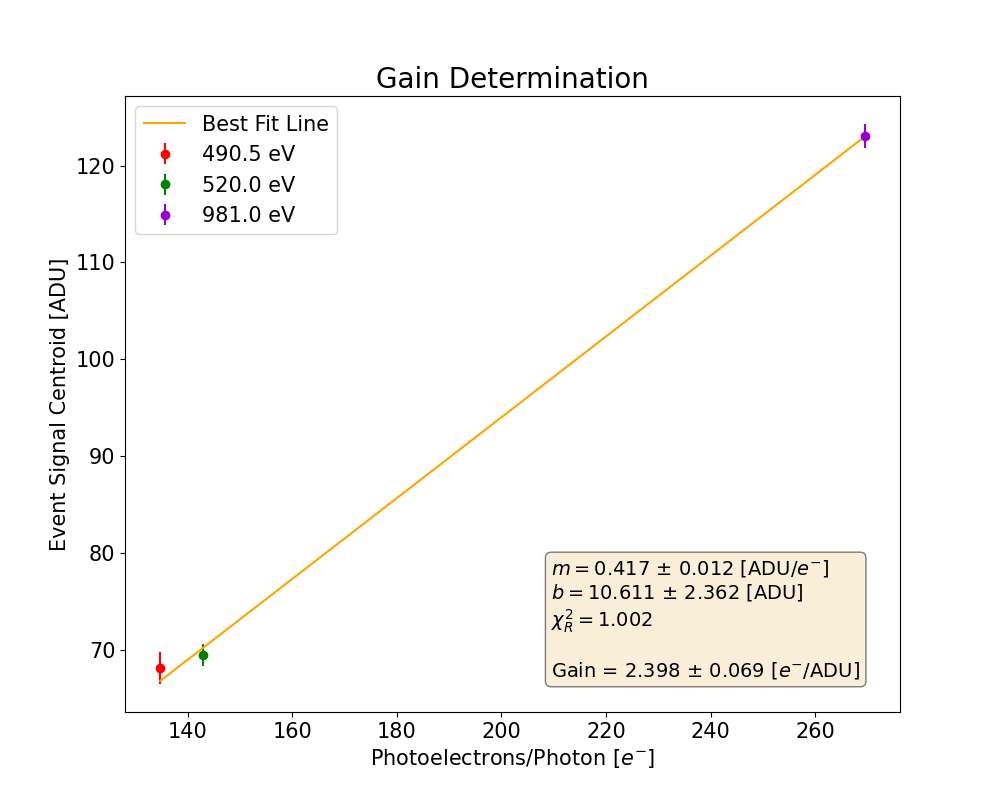

_________________________________
 Best Fit Parameters
 -----------------------------
 Slope: 0.41698 [ADU/e-]
 Slope Err: 0.01202 [ADU/e-]
 Gain: 2.398 [e-/ADU]
 Gain Err: 0.069 [e-/ADU]
 Reduced Chi Squared: 1.002


In [12]:
#Gain Determination CentroidsErrADU as error, now multiply erros by a factor of 108 to get a reduced chi squared close to 1 

error = CentroidsErrADU*108

Photoelectrons = Energies/wf

popt3, pcov3 = curve_fit(line, Photoelectrons, CentroidsADU, sigma=error, absolute_sigma=True)
perr3 = np.sqrt(np.diag(pcov3))

Slope = popt3[0]
SlopeErr = perr3[0]

b = popt3[1]
bErr = perr3[1]

Gain = 1/Slope
GainErr = SlopeErr/(Slope**2)

DataArray = CentroidsADU
ErrorArray = error
FitArray = line(Photoelectrons, *popt3)
NumberOfFitParameters = 2
ChiSquared, ReducedChiSquared, dof = ChiSquaredOfFit1D(DataArray,ErrorArray,FitArray,NumberOfFitParameters)

ReducedChiSquaredString = str(round(ReducedChiSquared,3))

plt.figure(figsize=(10,8))
plt.clf()

ax=plt.gca()

SlopeString = str(round(Slope,3))
SlopeErrString = str(round(SlopeErr,3))
bString = str(round(b,3))
bErrString = str(round(bErr,3))
GainString = str(round(Gain,3))
GainErrString = str(round(GainErr,3))




textstr = '\n'.join((
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " [ADU/$e^{-}$]",
    r'$b = $' + bString + " $\pm$ " + bErrString + " [ADU]",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " [$e^{-}$/ADU]"))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#plt.errorbar(Photoelectrons,CentroidsADU, yerr=SigmaADU, fmt = 'o', color = 'blue', label = 'ADU Centroids')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '490.5 eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '520.0 eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '981.0 eV')
plt.plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')

#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)

ax.text(0.55, 0.25, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Gain Determination')
plt.xlabel('Photoelectrons/Photon [$e^{-}$]')
plt.ylabel('Event Signal Centroid [ADU]')
plt.legend()
plt.show()



print("_________________________________")
print(" Best Fit Parameters")
print(" -----------------------------")
print(" Slope: " + str(round(Slope,5)) + " [ADU/e-]")
print(" Slope Err: " + str(round(SlopeErr,5)) + " [ADU/e-]")
print(" Gain: " + str(round(Gain,3)) + " [e-/ADU]")
print(" Gain Err: " + str(round(GainErr,3)) + " [e-/ADU]")
print(" Reduced Chi Squared: " + ReducedChiSquaredString)

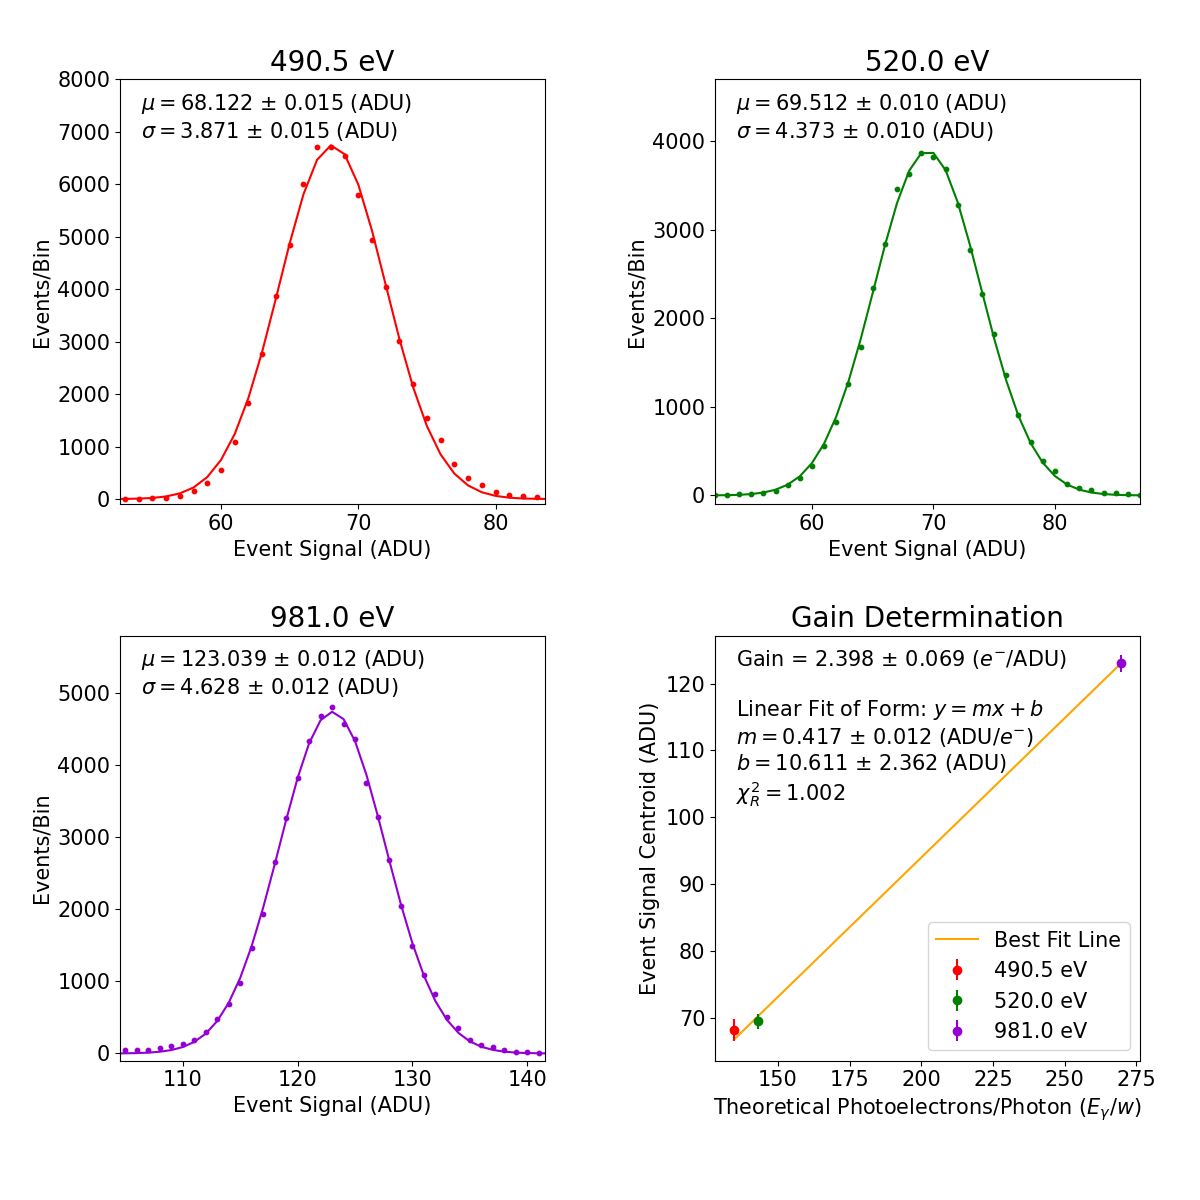

In [20]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
#    r' ',
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

textstrGain = '\n'.join((
    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
    r' ',
    r'Linear Fit of Form: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red',s=10 , label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8000))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,0].text(0.05, 0.97, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top')

#Plotting Top Right
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green',s=10 , label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,4700))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,1].text(0.05, 0.97, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top')

#Plotting Bottom Left
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet',s=10 , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,5800))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[1,0].text(0.05, 0.97, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top')


#Plotting Bottom Right


ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '490.5 eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '520.0 eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '981.0 eV')
ax[1,1].set_xlabel('Theoretical Photoelectrons/Photon ($E_{\gamma}/w$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Gain Determination", loc = 'center')
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
ax[1,1].text(0.05, 0.97, textstrGain, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top')
ax[1,1].legend(loc='lower right')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest1.png", dpi=200,bbox_inches='tight')

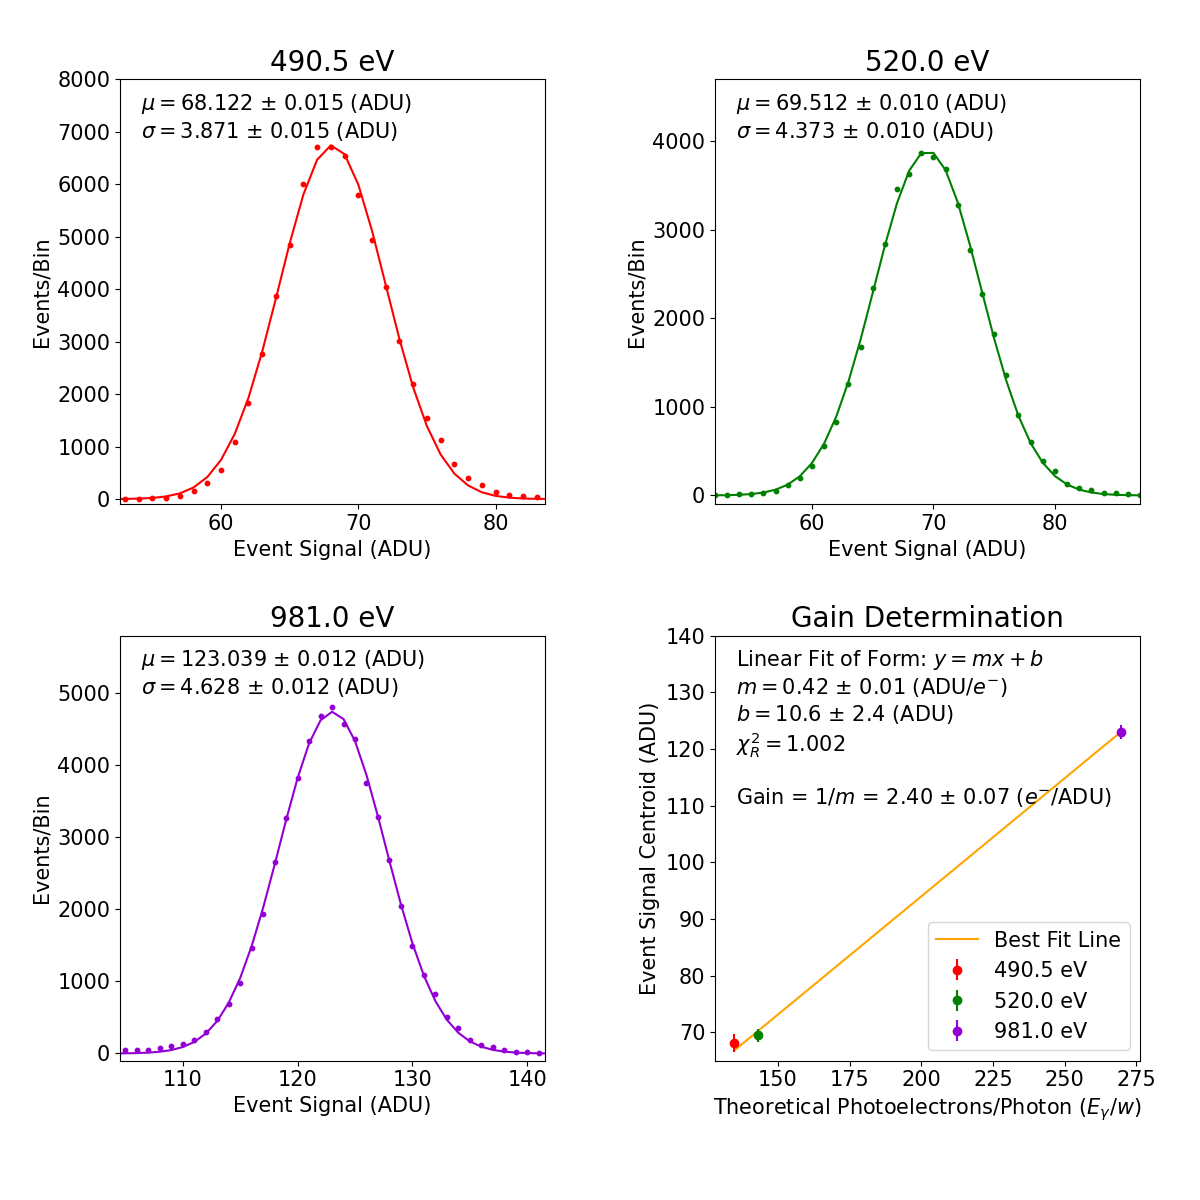

In [24]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,1))
bErrString = str(round(bErr,1))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit of Form: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red',s=10 , label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8000))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,0].text(0.05, 0.97, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top')

#Plotting Top Right
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green',s=10 , label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,4700))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,1].text(0.05, 0.97, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top')

#Plotting Bottom Left
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet',s=10 , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,5800))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[1,0].text(0.05, 0.97, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top')


#Plotting Bottom Right


ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '490.5 eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '520.0 eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '981.0 eV')
ax[1,1].set_xlabel('Theoretical Photoelectrons/Photon ($E_{\gamma}/w$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Gain Determination", loc = 'center')
ax[1,1].set(ylim=(65,140))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
ax[1,1].text(0.05, 0.97, textstrGain, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top')
ax[1,1].legend(loc='lower right')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest2.png", dpi=200,bbox_inches='tight')

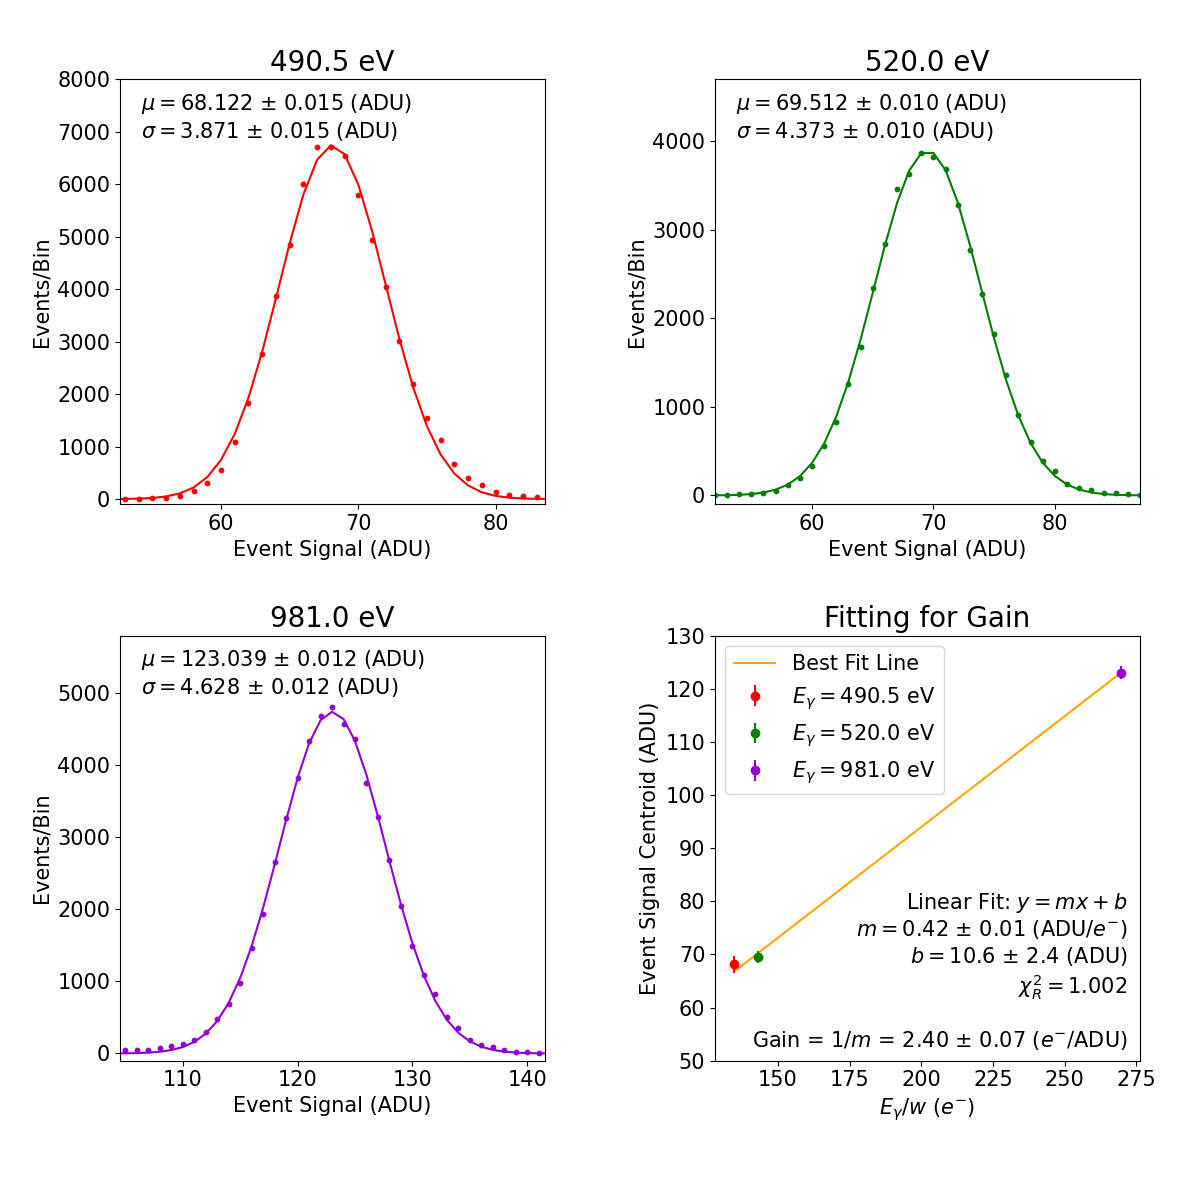

In [32]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,1))
bErrString = str(round(bErr,1))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red',s=10 , label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8000))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,0].text(0.05, 0.97, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top')

#Plotting Top Right
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green',s=10 , label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,4700))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,1].text(0.05, 0.97, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top')

#Plotting Bottom Left
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet',s=10 , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,5800))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[1,0].text(0.05, 0.97, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top')


#Plotting Bottom Right


ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '$E_{\gamma} = 490.5$ eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '$E_{\gamma} = 520.0$ eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '$E_{\gamma} = 981.0$ eV')
ax[1,1].set_xlabel('$E_{\gamma}/w$ ($e^{-}$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Fitting for Gain", loc = 'center')
ax[1,1].set(ylim=(50,130))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
ax[1,1].text(0.97, 0.40, textstrGain, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='right')
ax[1,1].legend(loc='upper left')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest3.png", dpi=200,bbox_inches='tight')

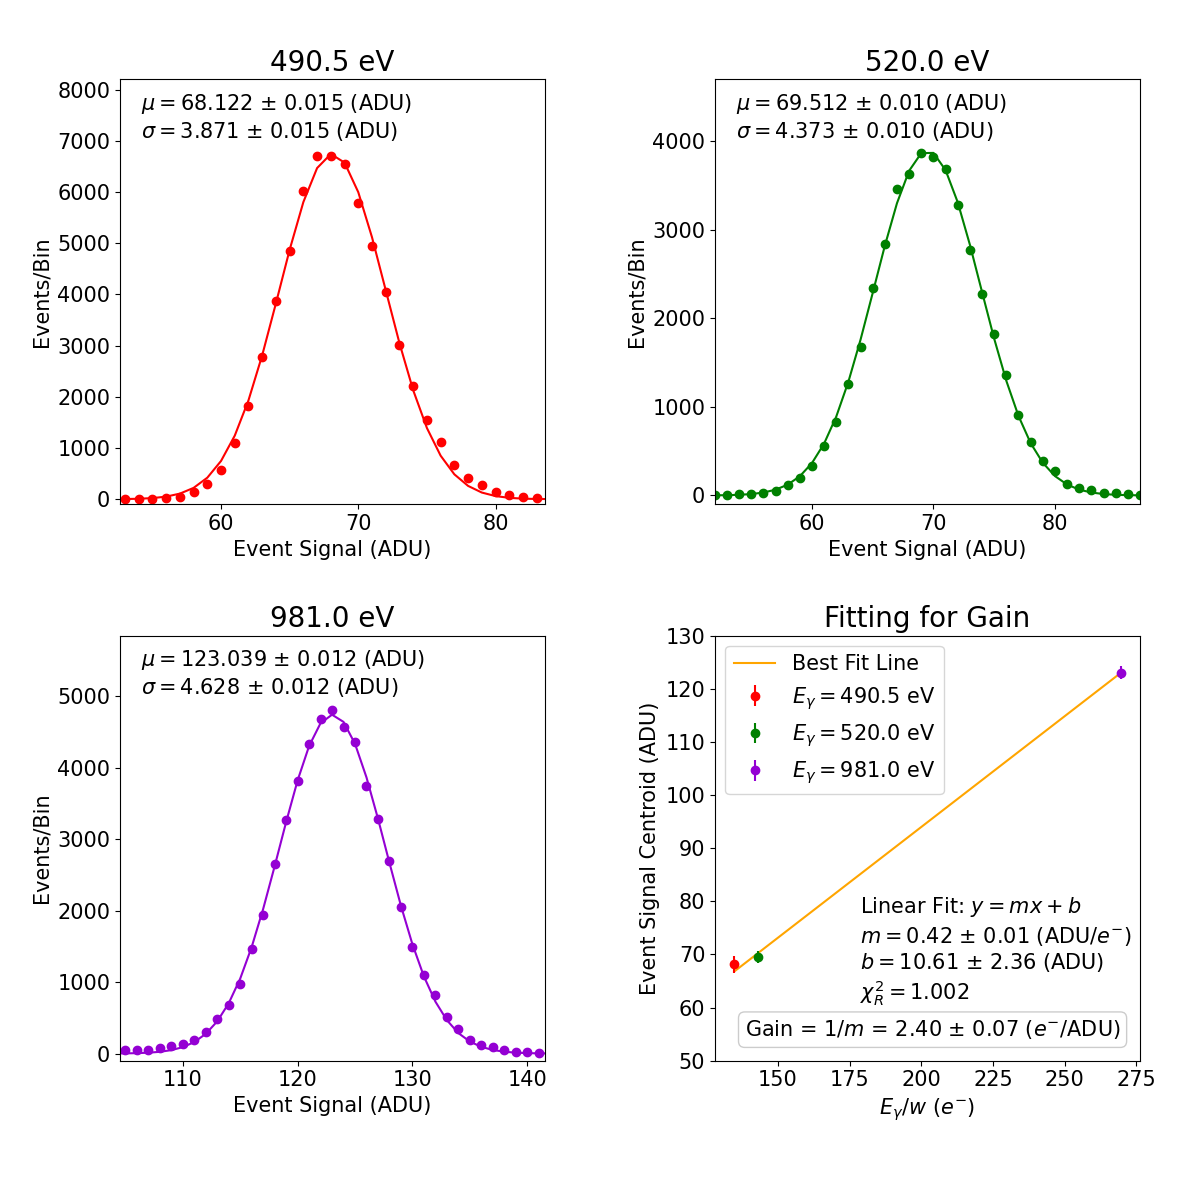

In [54]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,2))
bErrString = str(round(bErr,2))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

textstrGain1 = 'Linear Fit: $y=mx+b$'
textstrGain2 = '\n'.join((
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))
textstrGain3 = 'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red', label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8200))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,0].text(0.05, 0.97, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top')


#Plotting Top Right
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green', label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,4700))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[0,1].text(0.05, 0.97, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top')

#Plotting Bottom Left
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet' , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,5850))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
ax[1,0].text(0.05, 0.97, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top')


#Plotting Bottom Right

props = dict(boxstyle='round', fc="w", ec="k", alpha=0.2)

ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '$E_{\gamma} = 490.5$ eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '$E_{\gamma} = 520.0$ eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '$E_{\gamma} = 981.0$ eV')
ax[1,1].set_xlabel('$E_{\gamma}/w$ ($e^{-}$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Fitting for Gain", loc = 'center')
ax[1,1].set(ylim=(50,130))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
#ax[1,1].text(0.97, 0.40, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='right')
ax[1,1].text(0.34, 0.39, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.34, 0.32, textstrGain2, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left')
#ax[1,1].text(0.05, 0.07, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.07, 0.10, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left',bbox=props)
ax[1,1].legend(loc='upper left')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest4.png", dpi=200,bbox_inches='tight')

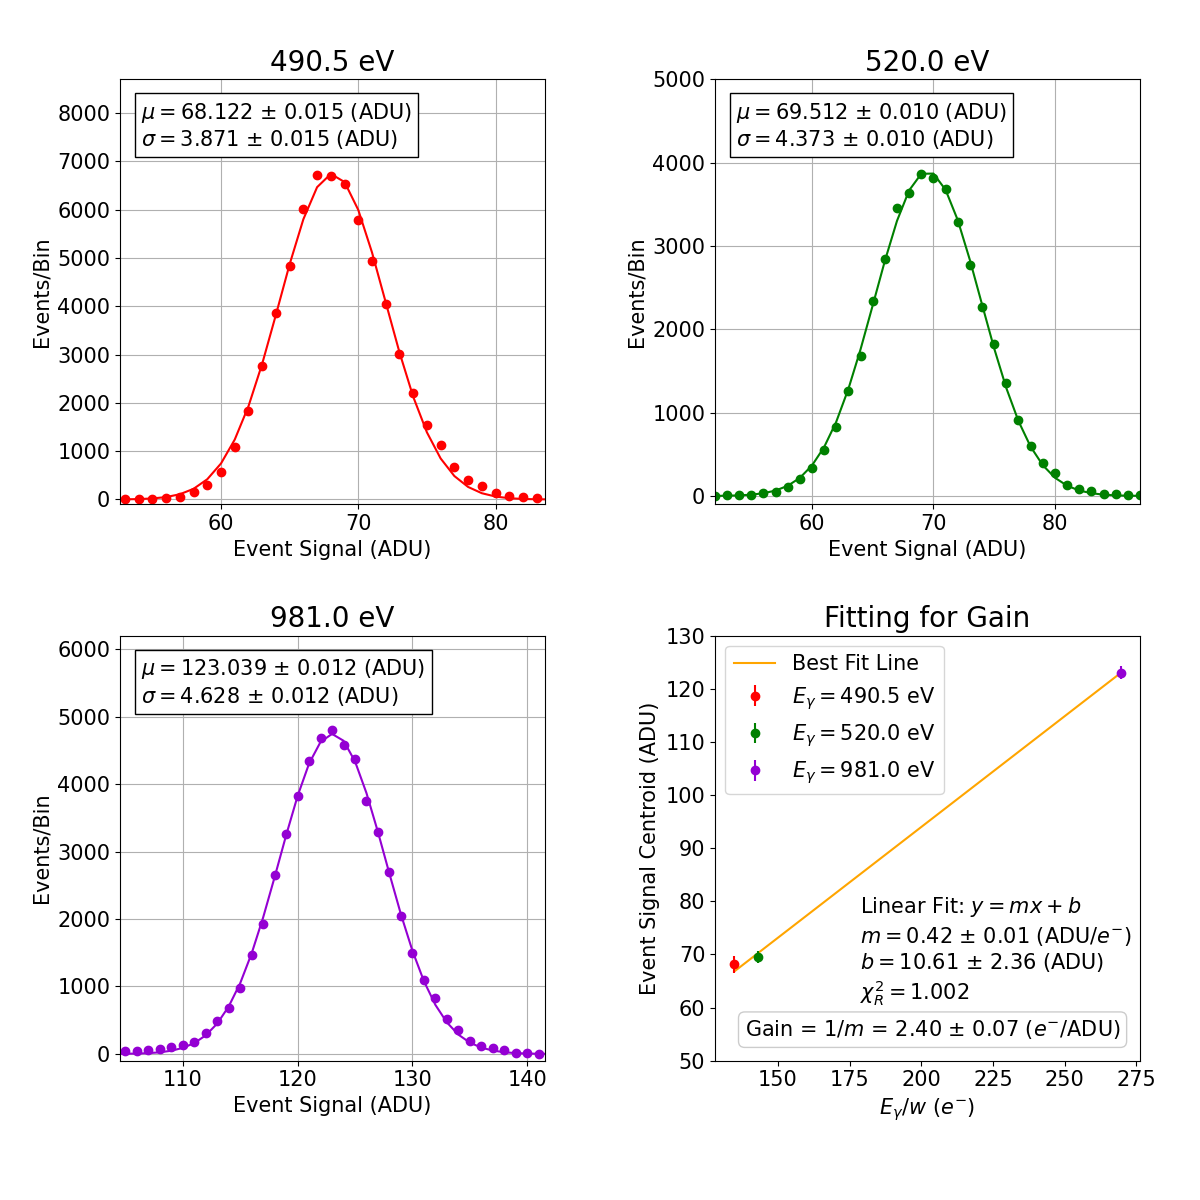

In [75]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,2))
bErrString = str(round(bErr,2))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

textstrGain1 = 'Linear Fit: $y=mx+b$'
textstrGain2 = '\n'.join((
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))
textstrGain3 = 'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].grid(True)
ax[0,0].set_axisbelow(True)
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red', label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8700))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,0].text(0.05, 0.95, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top', bbox=TL_Box)


#Plotting Top Right
ax[0,1].grid(True)
ax[0,1].set_axisbelow(True)
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green', label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,5000))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TR_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,1].text(0.05, 0.95, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top', bbox=TR_Box)

#Plotting Bottom Left
ax[1,0].grid(True)
ax[1,0].set_axisbelow(True)
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet' , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,6200))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
BL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[1,0].text(0.05, 0.95, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top',bbox=BL_Box)


#Plotting Bottom Right

props = dict(boxstyle='round', fc="w", ec="k", alpha=0.2)

ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', label = '$E_{\gamma} = 490.5$ eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', label = '$E_{\gamma} = 520.0$ eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', label = '$E_{\gamma} = 981.0$ eV')
ax[1,1].set_xlabel('$E_{\gamma}/w$ ($e^{-}$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Fitting for Gain", loc = 'center')
ax[1,1].set(ylim=(50,130))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
#ax[1,1].text(0.97, 0.40, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='right')
ax[1,1].text(0.34, 0.39, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.34, 0.32, textstrGain2, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left')
#ax[1,1].text(0.05, 0.07, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.07, 0.10, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left',bbox=props)
ax[1,1].legend(loc='upper left')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest5.png", dpi=200,bbox_inches='tight')

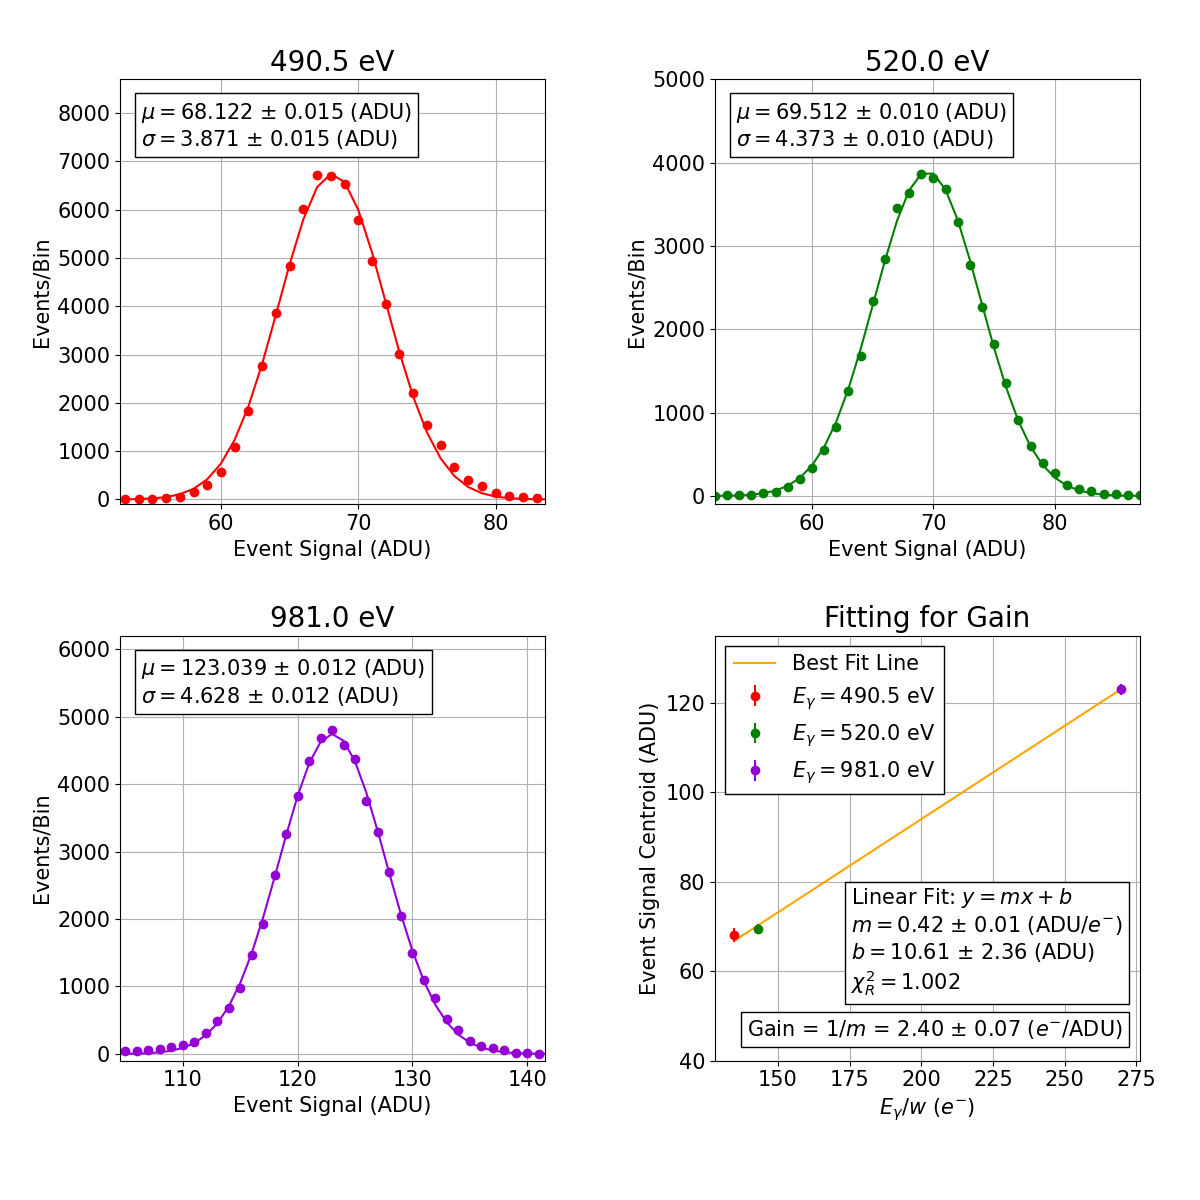

In [91]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,2))
bErrString = str(round(bErr,2))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

#textstrGain1 = 'Linear Fit: $y=mx+b$'
textstrGain1 = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))
textstrGain3 = 'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].grid(True)
ax[0,0].set_axisbelow(True)
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red', label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8700))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,0].text(0.05, 0.95, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top', bbox=TL_Box)


#Plotting Top Right
ax[0,1].grid(True)
ax[0,1].set_axisbelow(True)
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green', label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,5000))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TR_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,1].text(0.05, 0.95, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top', bbox=TR_Box)

#Plotting Bottom Left
ax[1,0].grid(True)
ax[1,0].set_axisbelow(True)
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet' , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,6200))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
BL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[1,0].text(0.05, 0.95, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top',bbox=BL_Box)


#Plotting Bottom Right

props = dict(boxstyle='square', fc="w", ec="k", alpha=1.0)
ax[1,1].grid(True)
ax[1,1].set_axisbelow(True)
ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', markersize=6, label = '$E_{\gamma} = 490.5$ eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', markersize=6, label = '$E_{\gamma} = 520.0$ eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', markersize=6, label = '$E_{\gamma} = 981.0$ eV')
ax[1,1].set_xlabel('$E_{\gamma}/w$ ($e^{-}$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Fitting for Gain", loc = 'center')
ax[1,1].set(ylim=(40,135))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
#ax[1,1].text(0.97, 0.40, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='right')
ax[1,1].text(0.32, 0.41, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left', bbox=props)
#ax[1,1].text(0.34, 0.32, textstrGain2, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
#ax[1,1].text(0.05, 0.07, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.075, 0.10, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left',bbox=props)
ax[1,1].legend(loc='upper left',fancybox=False, framealpha=1.0, edgecolor='black')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest6.png", dpi=200,bbox_inches='tight')

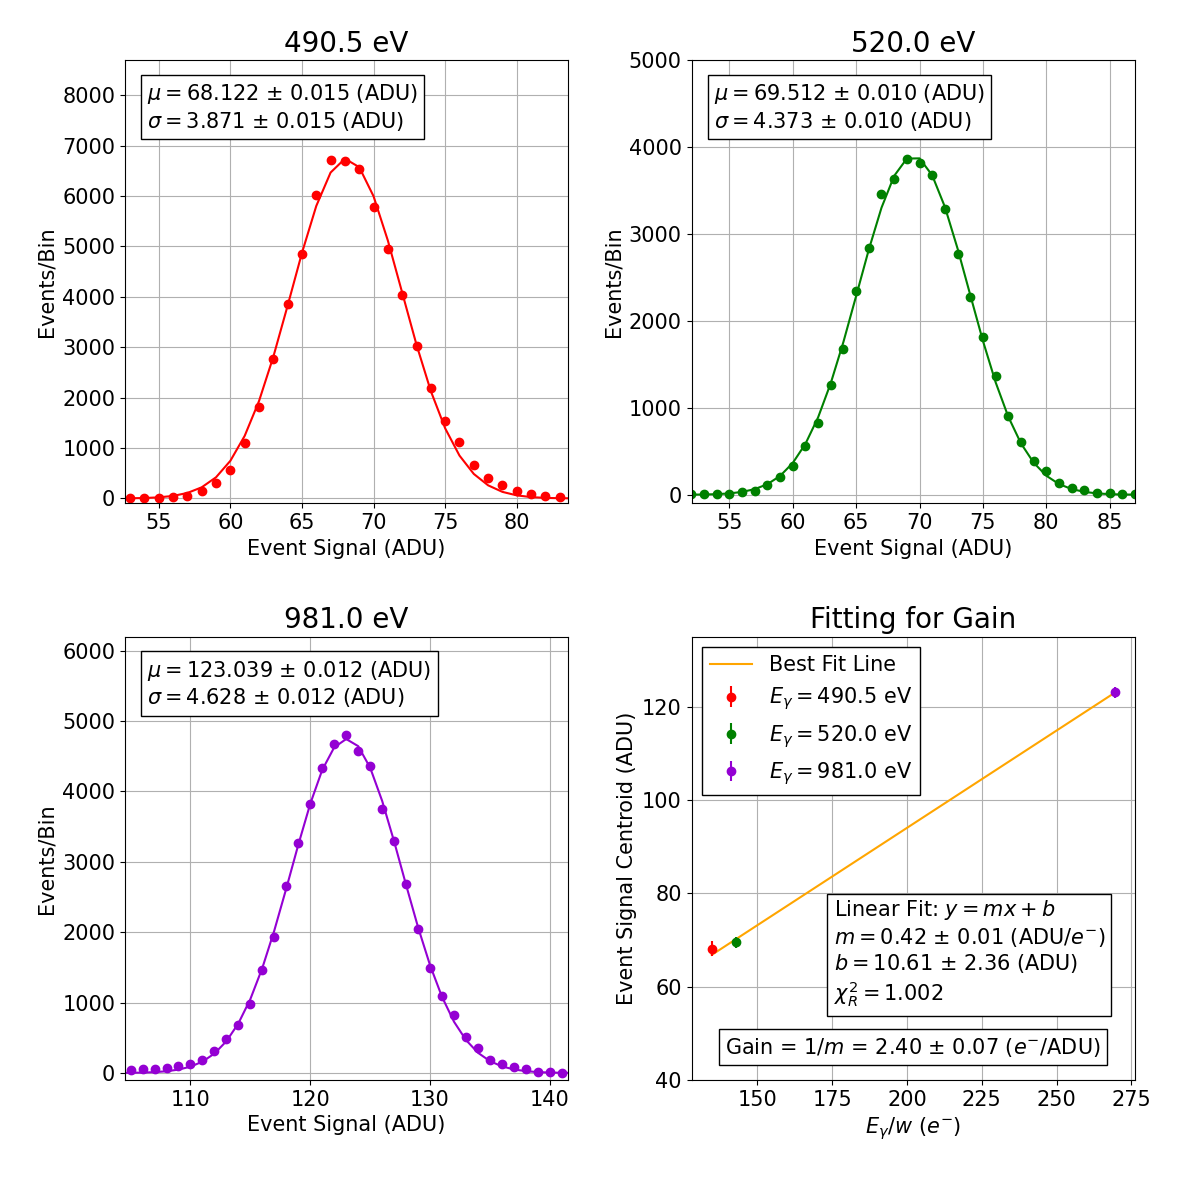

In [95]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,2))
bErrString = str(round(bErr,2))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

#textstrGain1 = 'Linear Fit: $y=mx+b$'
textstrGain1 = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))
textstrGain3 = 'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].grid(True)
ax[0,0].set_axisbelow(True)
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red', label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8700))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,0].text(0.05, 0.95, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top', bbox=TL_Box)


#Plotting Top Right
ax[0,1].grid(True)
ax[0,1].set_axisbelow(True)
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green', label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,5000))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TR_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,1].text(0.05, 0.95, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top', bbox=TR_Box)

#Plotting Bottom Left
ax[1,0].grid(True)
ax[1,0].set_axisbelow(True)
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet' , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,6200))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
BL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[1,0].text(0.05, 0.95, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top',bbox=BL_Box)


#Plotting Bottom Right

props = dict(boxstyle='square', fc="w", ec="k", alpha=1.0)
ax[1,1].grid(True)
ax[1,1].set_axisbelow(True)
ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', markersize=6, label = '$E_{\gamma} = 490.5$ eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', markersize=6, label = '$E_{\gamma} = 520.0$ eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', markersize=6, label = '$E_{\gamma} = 981.0$ eV')
ax[1,1].set_xlabel('$E_{\gamma}/w$ ($e^{-}$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Fitting for Gain", loc = 'center')
ax[1,1].set(ylim=(40,135))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
#ax[1,1].text(0.97, 0.40, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='right')
ax[1,1].text(0.32, 0.41, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left', bbox=props)
#ax[1,1].text(0.34, 0.32, textstrGain2, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
#ax[1,1].text(0.05, 0.07, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.075, 0.10, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left',bbox=props)
ax[1,1].legend(loc='upper left',fancybox=False, framealpha=1.0, edgecolor='black')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.25,
                    hspace=0.3)
plt.show()

plt.savefig("GainFigTest7.png", dpi=200,bbox_inches='tight')

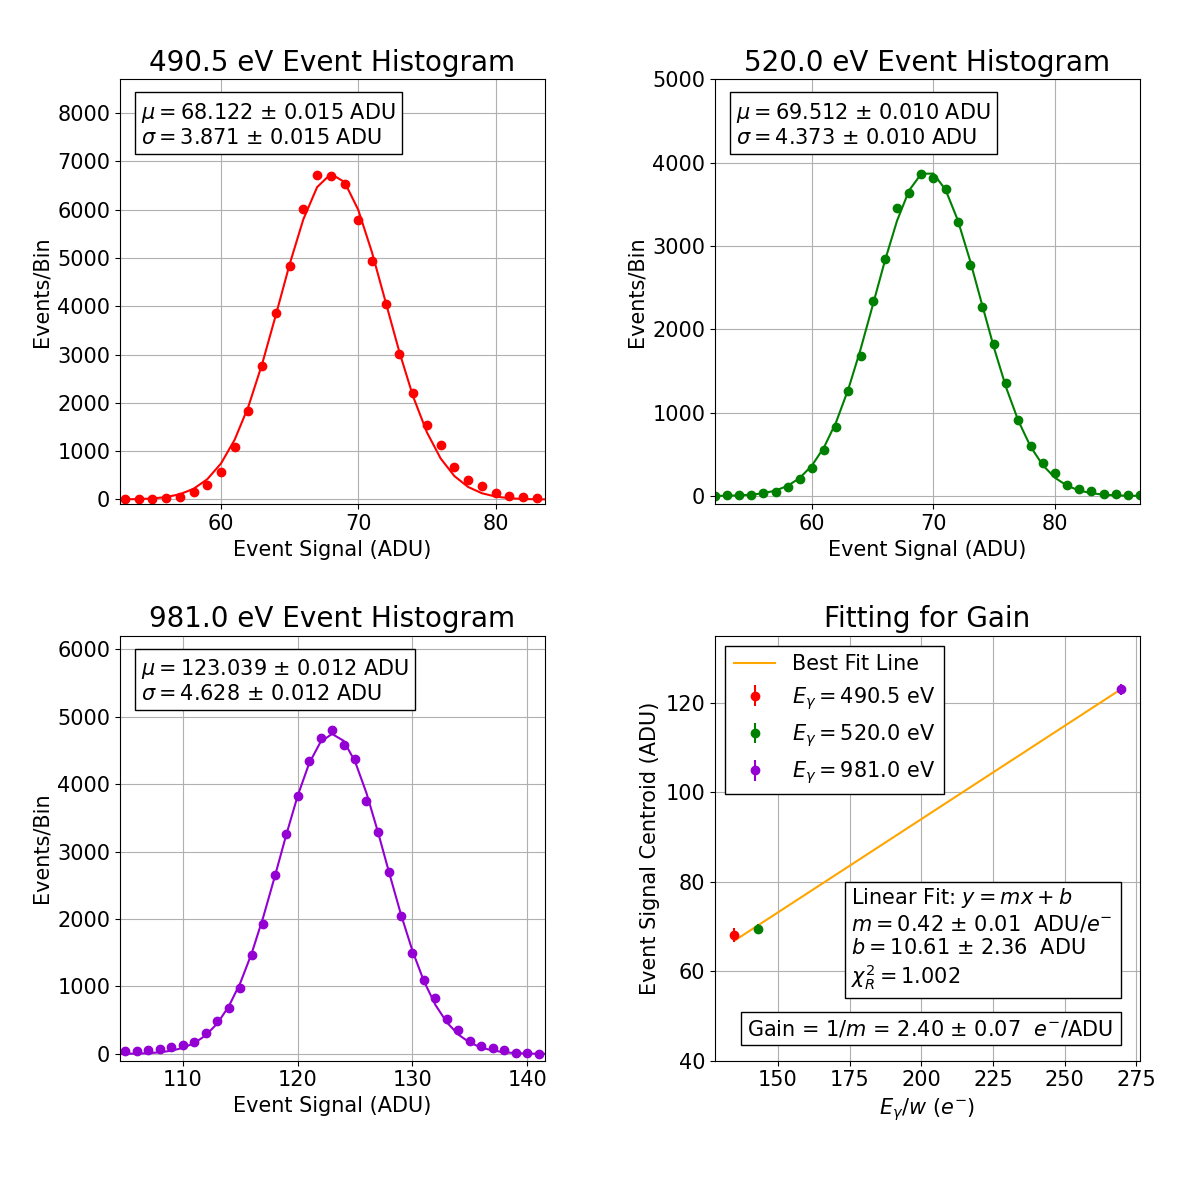

In [99]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " ADU",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " ADU"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 ADU",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 ADU"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " ADU",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " ADU"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,2))
bErrString = str(round(bErr,2))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

#textstrGain1 = 'Linear Fit: $y=mx+b$'
textstrGain1 = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + "  ADU/$e^{-}$ ",
    r'$b = $' + bString + " $\pm$ " + bErrString + "  ADU ",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))
textstrGain3 = 'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + "  $e^{-}$/ADU "

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].grid(True)
ax[0,0].set_axisbelow(True)
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red', label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV Event Histogram", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8700))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,0].text(0.05, 0.95, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top', bbox=TL_Box)


#Plotting Top Right
ax[0,1].grid(True)
ax[0,1].set_axisbelow(True)
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green', label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV Event Histogram", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,5000))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TR_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,1].text(0.05, 0.95, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top', bbox=TR_Box)

#Plotting Bottom Left
ax[1,0].grid(True)
ax[1,0].set_axisbelow(True)
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet' , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV Event Histogram", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,6200))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
BL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[1,0].text(0.05, 0.95, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top',bbox=BL_Box)


#Plotting Bottom Right

props = dict(boxstyle='square', fc="w", ec="k", alpha=1.0)
ax[1,1].grid(True)
ax[1,1].set_axisbelow(True)
ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', markersize=6, label = '$E_{\gamma} = 490.5$ eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', markersize=6, label = '$E_{\gamma} = 520.0$ eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', markersize=6, label = '$E_{\gamma} = 981.0$ eV')
ax[1,1].set_xlabel('$E_{\gamma}/w$ ($e^{-}$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Fitting for Gain", loc = 'center')
ax[1,1].set(ylim=(40,135))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
#ax[1,1].text(0.97, 0.40, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='right')
ax[1,1].text(0.32, 0.41, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left', bbox=props)
#ax[1,1].text(0.34, 0.32, textstrGain2, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
#ax[1,1].text(0.05, 0.07, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.075, 0.10, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left',bbox=props)
ax[1,1].legend(loc='upper left',fancybox=False, framealpha=1.0, edgecolor='black')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest8.png", dpi=200,bbox_inches='tight')

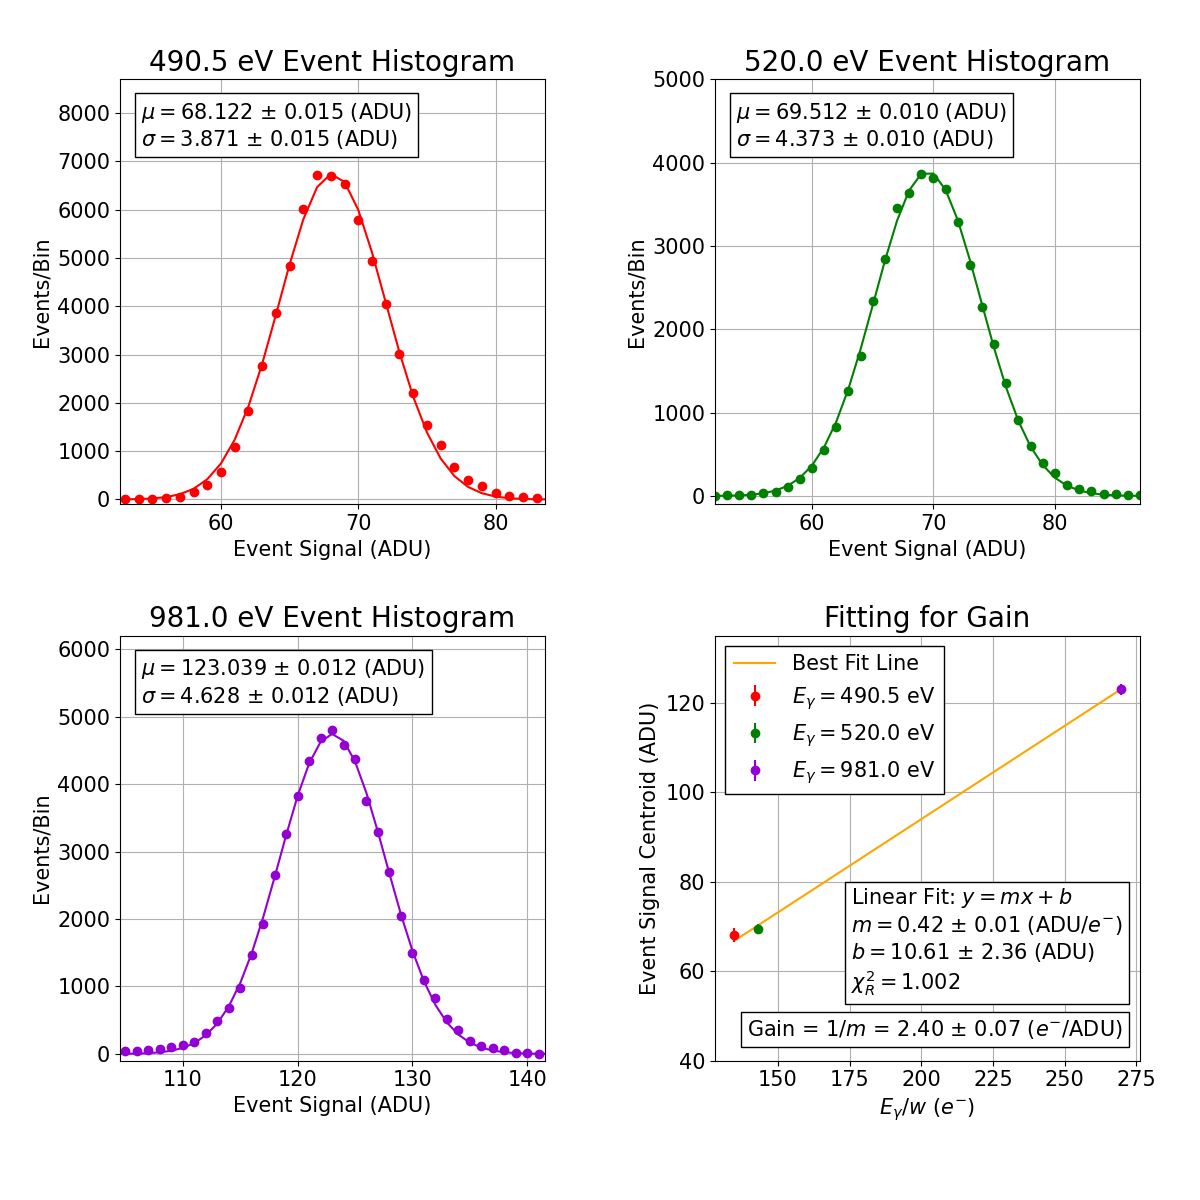

In [100]:
textstr490p5 = '\n'.join((
    r'$\mu = $' + Mu490p5 + " $\pm$ " + ErrMu490p5 + " (ADU)",
    r'$\sigma = $' + Sigma490p5+ " $\pm$ " + ErrSigma490p5 + " (ADU)"))

textstr520 = '\n'.join((
    r'$\mu = $' + Mu520 + " $\pm$ " + ErrMu520 + "0 (ADU)",
    r'$\sigma = $' + Sigma520+ " $\pm$ " + ErrSigma520 + "0 (ADU)"))

textstr981 = '\n'.join((
    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

#textstrGain = '\n'.join((
#    r'$\mu = $' + Mu981 + " $\pm$ " + ErrMu981 + " (ADU)",
#    r'$\sigma = $' + Sigma981+ " $\pm$ " + ErrSigma981 + " (ADU)"))

SlopeString = str(round(Slope,2))
SlopeErrString = str(round(SlopeErr,2))
bString = str(round(b,2))
bErrString = str(round(bErr,2))
GainString = str(round(Gain,2))
GainErrString = str(round(GainErr,2))

textstrGain = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString,
    r' ',
    r'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"))

#textstrGain1 = 'Linear Fit: $y=mx+b$'
textstrGain1 = '\n'.join((
    r'Linear Fit: $y=mx+b$',
    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))
textstrGain3 = 'Gain = $1/m$ = ' + GainString + "0 $\pm$ " + GainErrString + " ($e^{-}$/ADU)"

#textstrGain = '\n'.join((
#    r'Gain = ' + GainString + " $\pm$ " + GainErrString + " ($e^{-}$/ADU)",
#    r' ',
#    r'Linear Fit of Form: $y=mx+b$',
#    r'$m = $' + SlopeString + " $\pm$ " + SlopeErrString + " (ADU/$e^{-}$)",
#    r'$b = $' + bString + " $\pm$ " + bErrString + " (ADU)",
#    r'$\chi^{2}_{R} = $' + ReducedChiSquaredString))

f, ax = plt.subplots(2, 2)

#Plotting Top Left
ax[0,0].grid(True)
ax[0,0].set_axisbelow(True)
ax[0,0].scatter(xAxis_490p5,yAxis_490p5, color = 'red', label = '490.5 eV')
ax[0,0].plot(xAxis_490p5,Fit_yAxis_490p5, color = 'red' , label = '490.5 eV Double Gauss Fit')
ax[0,0].set_xlabel('Event Signal (ADU)')
ax[0,0].set_ylabel('Events/Bin')
ax[0,0].set_title("490.5 eV Event Histogram", loc = 'center')
#ax[0,0].axis('equal')
ax[0,0].set(xlim=(nMu490p5-4*nSigma490p5,nMu490p5+4*nSigma490p5), ylim=(-100,8700))
#ax[0,0].set_aspect('equal')
ax[0,0].set_aspect(1.0/ax[0,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,0].text(0.05, 0.95, textstr490p5, transform=ax[0,0].transAxes, fontsize=15,
        verticalalignment='top', bbox=TL_Box)


#Plotting Top Right
ax[0,1].grid(True)
ax[0,1].set_axisbelow(True)
ax[0,1].scatter(xAxis_520,yAxis_520, color = 'green', label = '520.0 eV')
ax[0,1].plot(xAxis_520,Fit_yAxis_520, color = 'green' , label = '520.0 eV Double Gauss Fit')
ax[0,1].set_xlabel('Event Signal (ADU)')
ax[0,1].set_ylabel('Events/Bin')
ax[0,1].set_title("520.0 eV Event Histogram", loc = 'center')
ax[0,1].set(xlim=(nMu520-4*nSigma520,nMu520+4*nSigma520), ylim=(-100,5000))
ax[0,1].set_aspect(1.0/ax[0,1].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
TR_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[0,1].text(0.05, 0.95, textstr520, transform=ax[0,1].transAxes, fontsize=15,
        verticalalignment='top', bbox=TR_Box)

#Plotting Bottom Left
ax[1,0].grid(True)
ax[1,0].set_axisbelow(True)
ax[1,0].scatter(xAxis_981,yAxis_981, color = 'darkviolet' , label = '981.0 eV')
ax[1,0].plot(xAxis_981,Fit_yAxis_981, color = 'darkviolet' , label = '981.0 eV Double Gauss Fit')
ax[1,0].set_xlabel('Event Signal (ADU)')
ax[1,0].set_ylabel('Events/Bin')
ax[1,0].set_title("981.0 eV Event Histogram", loc = 'center')
ax[1,0].set(xlim=(nMu981-4*nSigma981,nMu981+4*nSigma981), ylim=(-100,6200))
ax[1,0].set_aspect(1.0/ax[1,0].get_data_ratio(), adjustable='box')
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax[0,0].text(0.39, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        #verticalalignment='top', bbox=props)
BL_Box = dict(boxstyle='square', fc="w", ec="k", alpha=1)
ax[1,0].text(0.05, 0.95, textstr981, transform=ax[1,0].transAxes, fontsize=15,
        verticalalignment='top',bbox=BL_Box)


#Plotting Bottom Right

props = dict(boxstyle='square', fc="w", ec="k", alpha=1.0)
ax[1,1].grid(True)
ax[1,1].set_axisbelow(True)
ax[1,1].plot(Photoelectrons, line(Photoelectrons, *popt3), color = 'orange', label = 'Best Fit Line')
plt.errorbar([Photoelectrons[0]],[CentroidsADU[0]], yerr=[error[0]], fmt = 'o', color = 'red', markersize=6, label = '$E_{\gamma} = 490.5$ eV')
plt.errorbar([Photoelectrons[1]],[CentroidsADU[1]], yerr=[error[1]], fmt = 'o', color = 'green', markersize=6, label = '$E_{\gamma} = 520.0$ eV')
plt.errorbar([Photoelectrons[2]],[CentroidsADU[2]], yerr=[error[2]], fmt = 'o', color = 'darkviolet', markersize=6, label = '$E_{\gamma} = 981.0$ eV')
ax[1,1].set_xlabel('$E_{\gamma}/w$ ($e^{-}$)')
ax[1,1].set_ylabel('Event Signal Centroid (ADU)')
ax[1,1].set_title("Fitting for Gain", loc = 'center')
ax[1,1].set(ylim=(40,135))
ax[1,1].set_aspect(1.0/ax[1,1].get_data_ratio(), adjustable='box')
#ax[1,1].text(0.97, 0.40, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='right')
ax[1,1].text(0.32, 0.41, textstrGain1, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left', bbox=props)
#ax[1,1].text(0.34, 0.32, textstrGain2, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
#ax[1,1].text(0.05, 0.07, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
#        verticalalignment='top',horizontalalignment='left')
ax[1,1].text(0.075, 0.10, textstrGain3, transform=ax[1,1].transAxes, fontsize=15,
        verticalalignment='top',horizontalalignment='left',bbox=props)
ax[1,1].legend(loc='upper left',fancybox=False, framealpha=1.0, edgecolor='black')
f.set_size_inches(12, 12)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.4,
                    hspace=0.2)
plt.show()

plt.savefig("GainFigTest9.png", dpi=200,bbox_inches='tight')